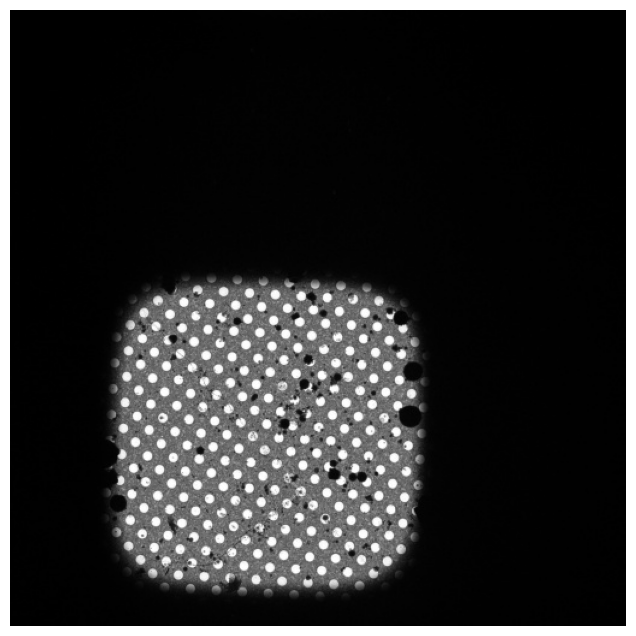

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread("GridSquare_20241015_171302.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

def display_image(image, points=None):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')

    if points is not None:
        for point in points:
            plt.plot(point[0], point[1], 'co')  # Plot points in red

    plt.axis('off')  # Hide axis

display_image(img)

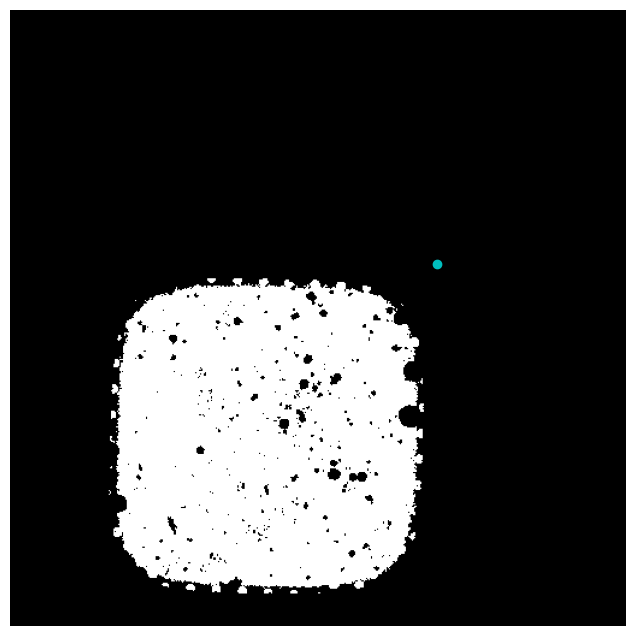

In [2]:
img_bin = cv2.resize(img, (0,0), fx=1, fy=1, interpolation=cv2.INTER_NEAREST)

img_t, thresh = cv2.threshold(img_bin, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

centroid = np.mean(np.argwhere(thresh == 255), axis=0).astype(int)

display_image(thresh, points=[centroid])

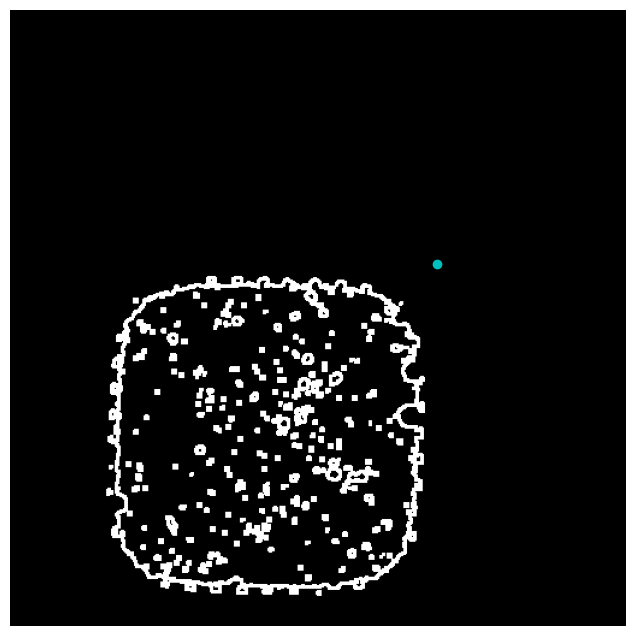

In [3]:
edges = cv2.Canny(thresh, 100, 200)

edges = cv2.dilate(edges, None)

display_image(edges, points=[centroid])

Number of labels: 157


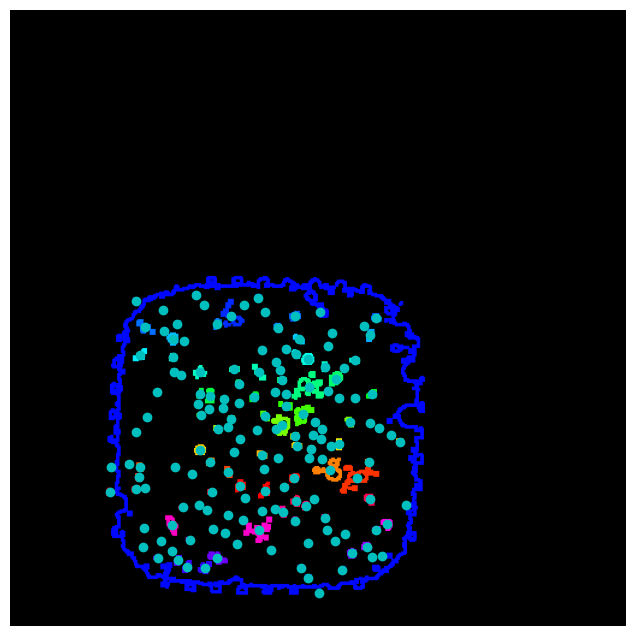

In [4]:
n_labels, edges_labeled, stats, centroids = cv2.connectedComponentsWithStats(edges)

print(f"Number of labels: {n_labels}")

label_hue = np.uint8(179*edges_labeled/np.max(edges_labeled))
blank_ch = 255*np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

labeled_img[label_hue==0] = 0

display_image(labeled_img, points=centroids)

Found 360 contours


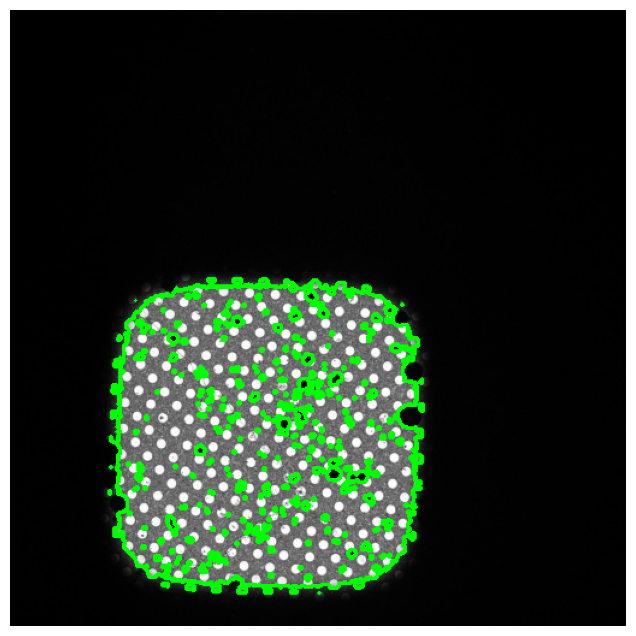

In [5]:
# Find contours to create regions for containment analysis
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

print(f"Found {len(contours)} contours")

# Visualize all contours
img_contours = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)

display_image(img_contours)

Found 35 contours


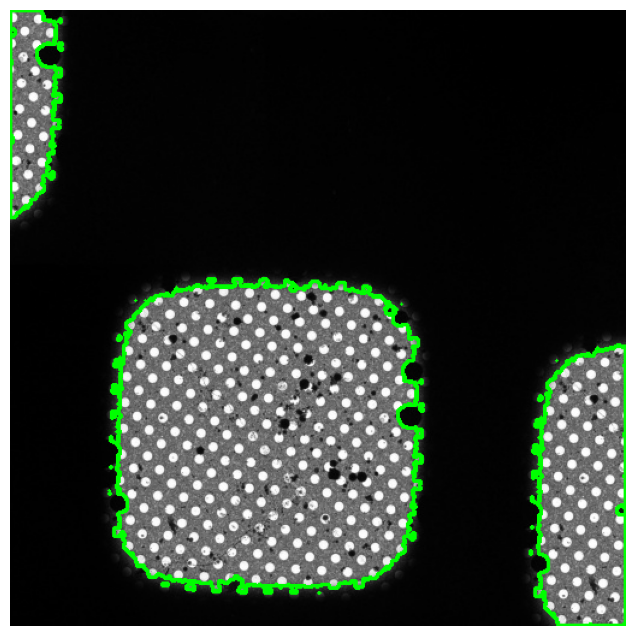

In [6]:
def translate_img(thresh, offset):
    M = np.float32([[1, 0, offset[0]], [0, 1, offset[1]]])
    shifted = cv2.warpAffine(thresh, M, (thresh.shape[1], thresh.shape[0]))
    return shifted

img_t1 = translate_img(img, (350, 50))
img_t2 = translate_img(img, (-300, -300))
img_t3 = translate_img(img, (0, 0))


img_t12 = cv2.addWeighted(img_t1, 1, img_t2, 1, 0)
img_t12 = cv2.addWeighted(img_t12, 1, img_t3, 1, 0)


img_t12_filt = cv2.blur(img_t12, (5, 5))

imgl, thresh_t_filt = cv2.threshold(img_t12, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


# Find contours to create regions for containment analysis
contours, hierarchy = cv2.findContours(thresh_t_filt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

print(f"Found {len(contours)} contours")

# Visualize all contours
img_contours = cv2.cvtColor(img_t12, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)

display_image(img_contours)

In [7]:
def border_contour(contour, img) -> bool:
    x, y, w, h = cv2.boundingRect(contour)
    if x <= 1 or y <= 1 or (x + w) >= (img.shape[1] - 1) or (y + h) >= (img.shape[0] - 1):
        print("Border contour")
        return True
    print("Not a border contour")
    return False

Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Border contour
Border contour, skipping
Too small
Too small
Too small
Too small
Too small
Not a border contour
Too small
Too small
Too small
Too small
Border contour
Border contour, skipping


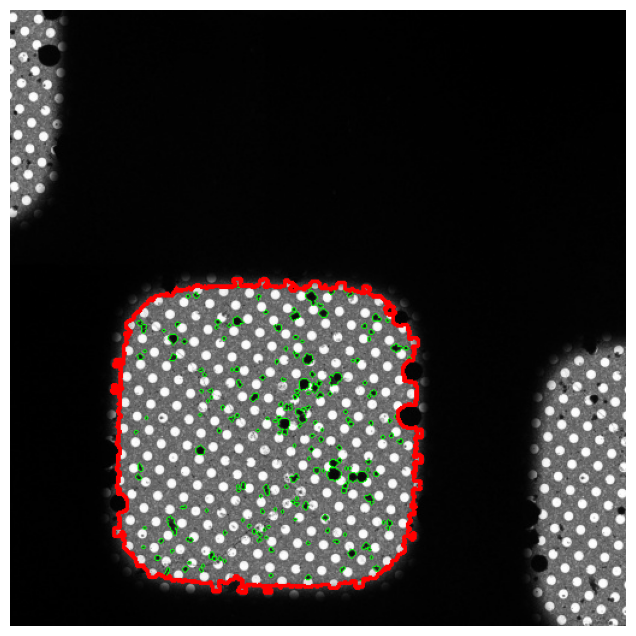

In [8]:
# Visualize all contours

valid_contours = []
for c, h in zip(contours, hierarchy[0]):
    if cv2.contourArea(c) < 400:
        print("Too small")
        continue
    elif border_contour(c, img_t12):
        print("Border contour, skipping")
        continue
    else:
        valid_contours.append(c)

inner_contours = []
for c in valid_contours:
    mask = np.zeros(img_t12.shape, dtype=np.uint8)
    cv2.drawContours(mask, [c], -1, 255, thickness=cv2.FILLED)  # Fill the contour
    masked_img = cv2.bitwise_and(img_t12, img_t12, mask=mask)
    
    masked_img = cv2.threshold(masked_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    contours, hierarchy = cv2.findContours(masked_img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

    for j, (ic, ih) in enumerate(zip(contours, hierarchy[0])):
        if ih[3] != -1 and cv2.contourArea(ic) > 2:
            inner_contours.append(ic)
            
    

draw_contours = cv2.cvtColor(img_t12, cv2.COLOR_GRAY2BGR)
cv2.drawContours(draw_contours, inner_contours, -1, (0, 255, 0), thickness=1)
cv2.drawContours(draw_contours, valid_contours, -1, (255, 0, 0), thickness=2)

display_image(draw_contours)    

In [9]:
%%bash

ls /usr/local/IMOD/bin/imodholefinder

imodholefinder --help

/usr/local/IMOD/bin/imodholefinder
imodholefinder Version 5.1.6 Oct  6 2025 03:45:03
Copyright (C) 1994-2025 by the Regents of the University of Colorado
Usage: imodholefinder [Options] input_file output_file
Options can be abbreviated, current short name abbreviations are in parentheses
Options:
 -input (-inp)  OR  -InputImageFile   File
    Input image filename
 -output (-o)  OR  -OutputModelFile   File
    Output model filename
 -boundary (-bo)  OR  -BoundaryModel   File
    Model with contours enclosing areas to analyze, one per section
 -summary (-su)  OR  -SummaryOutputFile   File
    Name of output file for points and values found on each section
 -diameter (-di)  OR  -DiameterOfHoles   Float
    Nominal diameter of holes in microns, or negative pixels (required)
 -spacing (-sp)  OR  -SpacingOfHoles   Float
    Nominal spacing between holes in microns, or negative pixels (required)
 -hex  OR  -HexagonalGrid
    Holes are arranged in a hexagonal rather than a square lattice
 -err